In [ ]:
  ### https://pypi.org/project/scispacy/ refer for more details

In [11]:
#!pip install spacy
#!pip install scispacy
#!pip install negspacy

#used models: ['en_core_sci_sm' (biomedical data), 'en_ner_bc5cdr_md' (BC5CDR corpus)]
# !pip install "https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.5/en_ner_bc5cdr_md-0.2.5.tar.gz"
#!pip install "https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.5/en_core_sci_sm-0.2.5.tar.gz"

  Created wheel for en-core-sci-sm: filename=en_core_sci_sm-0.2.5-py3-none-any.whl size=33155839 sha256=baede096b6e6d3152b80b5558c8cd555704d6b2a2338c60446749956ba1cb06b
  Stored in directory: c:\users\administrator\appdata\local\pip\cache\wheels\0d\42\4c\0abd97494c726adedef064a3c4ef68a7c77223f439df22302f
Successfully built en-core-sci-sm


In [4]:
import spacy
import scispacy
import negspacy

import spacy
import scispacy
from spacy import displacy
from spacy.matcher import PhraseMatcher
from spacy.tokens import Span
from negspacy.negation import Negex

In [24]:
import en_core_sci_sm
import en_ner_bc5cdr_md

In [25]:
## download the below using url and load it

nlp0 = en_core_sci_sm.load()
nlp1 = en_ner_bc5cdr_md.load()

In [26]:
#Sample Input Clinical Note

clinical_note = "Patient resting in bed. Patient given azithromycin without any difficulty. Patient has audible wheezing, \
states chest tightness. No evidence of hypertension.\
Patient denies nausea at this time. zofran declined. Patient is also having intermittent sweating associated with pneumonia. \
Patient refused pain but tylenol still given. Neither substance abuse nor alcohol use however cocaine once used in the last year. Alcoholism unlikely.\
Patient has headache and fever. Patient is not diabetic. \
No signs of diarrhea. Lab reports confirm lymphocytopenia. Cardaic rhythm is Sinus bradycardia. \
Patient also has a history of cardiac injury. No kidney injury reported. No abnormal rashes or ulcers. \
Patient might not have liver disease. Confirmed absence of hemoptysis. Although patient has severe pneumonia and fever \
, test reports are negative for COVID-19 infection. COVID-19 viral infection absent."

In [29]:
## NLP pipe line implementation

## Lemmatizing the notes to capture all types of negation(eg: deny,denies,denying)

def lemmatize(note,nlp):
    doc = nlp(note)
    lemNote = [i.lemma_ for i in doc]
    return " ".join(lemNote)

lem_clinical_note = lemmatize(clinical_note,nlp0)

#creating a doc object using BC5CDR model
doc = nlp1(lem_clinical_note)

In [32]:
displacy.render(doc,style='ent')

In [33]:
# Feature Extractor: Named Entities

#function to modify options for displacy NER visualization
def get_entity_options():
    entities = ["DISEASE", "CHEMICAL", "NEG_ENTITY"]
    colors = {'DISEASE': 'linear-gradient(180deg, #66ffcc, #abf763)', 'CHEMICAL': 'linear-gradient(90deg, #aa9cfc, #fc9ce7)', "NEG_ENTITY":'linear-gradient(90deg, #ffff66, #ff6600)'}
    options = {"ents": entities, "colors": colors}    
    return options
options = get_entity_options()
#visualizing identified Named Entities in clinical input text 
displacy.render(doc, style='ent', options=options)

In [36]:
#Feature Extractor: Negation Detection


#adding a new pipeline component to identify negation
def neg_model(nlp_model):
    nlp = en_ner_bc5cdr_md.load(disable = ['parser'])
    nlp.add_pipe(nlp.create_pipe('sentencizer'))
    negex = Negex(nlp)
    nlp.add_pipe(negex)
    return nlp

"""
Negspacy sets a new attribute e._.negex to True if a negative concept is encountered
"""
def negation_handling(nlp_model, note, neg_model):
    results = []
    nlp = neg_model(nlp_model) 
    note = note.split(".") #sentence tokenizing based on delimeter 
    note = [n.strip() for n in note] #removing extra spaces at the begining and end of sentence
    for t in note:
        doc = nlp(t)
        for e in doc.ents:
            rs = str(e._.negex)
            if rs == "True": 
                results.append(e.text)
    return results

#list of negative concepts from clinical note identified by negspacy
results0 = negation_handling(nlp1, lem_clinical_note, neg_model)

In [42]:
#Updating Negative Entity Labels (DISEASE/CHEMICAL-> NEG_ENTITY)
#function to identify span objects of matched megative phrases from clinical note
def match(nlp,terms,label):
        patterns = [nlp.make_doc(text) for text in terms]
        matcher = PhraseMatcher(nlp.vocab)
        matcher.add(label, None, *patterns)
        return matcher
    
    
#replacing the labels for identified negative entities
def overwrite_ent_lbl(matcher, doc):
    matches = matcher(doc)
    seen_tokens = set()
    new_entities = []
    entities = doc.ents
    for match_id, start, end in matches:
        if start not in seen_tokens and end - 1 not in seen_tokens:
            new_entities.append(Span(doc, start, end, label=match_id))
            entities = [e for e in entities if not (e.start < end and e.end > start)]
            seen_tokens.update(range(start, end))
            doc.ents = tuple(entities) + tuple(new_entities)
    return doc


matcher = match(nlp1, results0, "NEG_ENTITY")
#doc0: new doc object with added "NEG_ENTITY label"
doc0 = overwrite_ent_lbl(matcher,doc)
#visualizing identified Named Entities in clinical input text 
displacy.render(doc0, style='ent', options=options)

In [43]:
## Are we able to identify all the negative entities present in the text? No
## patient deny nausea at this time: nausea is not treated as a negative term
## patient refuse pain but tylenol still give: pain is not treated as a negative term
## covid-19 viral infection absent: viral infection is not treated as a negative term

    

# Adding custom negation concepts

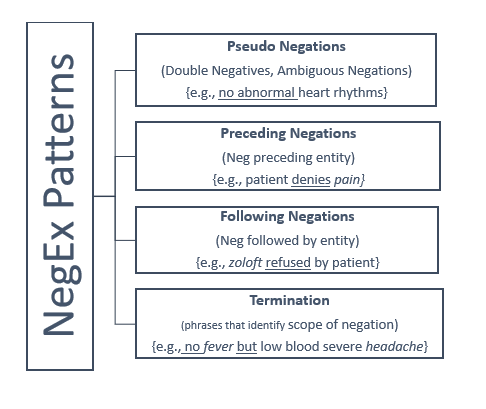

In [45]:
#function to add custom negation terms to the existing model
def neg_model2(nlp_model):
    nlp = en_ner_bc5cdr_md.load(disable = ['parser'])
    nlp.add_pipe(nlp.create_pipe('sentencizer'))
    negex = Negex(nlp)
    
    negex.preceding_patterns += [nlp('deny'), nlp('refuse'), nlp('neither'), nlp('nor')]
    negex.following_patterns += [nlp('absent'), nlp('deny'), nlp('decline')]
    preceding_update  = [i.text for i in negex.preceding_patterns]
    following_update = [i.text for i in negex.following_patterns]
        
    negex = Negex(nlp, preceding_negations = preceding_update, following_negations= following_update)
    nlp.add_pipe(negex)
    return nlp
#updated list of all the negative concepts from clinical note identified by negspacy
results1 = negation_handling("en_ner_bc5cdr_md", lem_clinical_note, neg_model2)
matcher = match(nlp1, results1,"NEG_ENTITY")
#doc1: new doc object with added custom concepts for "NEG_ENTITY label"
doc1 = overwrite_ent_lbl(matcher,doc)
#visualizing identified Named Entities in clinical input text 
displacy.render(doc, style='ent', options=options)

In [ ]:
## Limitation
### The negex patterns in the model are not added considering the preprocessing step that involves lemmatization. Lemmatization is an important part of NLP processing. If not considered, we might end up creating a model that is too tight to the concepts.
### for instance: the negex patterns include: “denies”, “denying” but not “deny”.
### Therefore, if the negation concepts are added keeping lemmatization in mind then we might end up extracting a lot more concepts based on a lot less terminology.

In [ ]:
"""https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5863758/
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4231086/
https://www.aclweb.org/anthology/W13-5635.pdf"""